In [1]:
using Revise
import SSD

Precompiling SSD
  ✓ SSD
  1 dependency successfully precompiled in 10 seconds. 66 already precompiled.


In [2]:
using CPUTime
using CSV
using DataFrames
using Dates
using DelimitedFiles
using Distributions
using Distances
using Gurobi
using LinearAlgebra
using Plots
using Random

In [ ]:
using TimerOutputs

# Create a TimerOutput, this is the main type that keeps track of everything.
const to = TimerOutput()

In [ ]:
function get_res(file)
    extract = false
    instance = ""
    method = ""
    lb = -99
    ub = -99
    cpu_t = -99
    status = ""
    iter = -99
    mess = ""
    backup = ""
    i=1
    open(file,"r") do f  
        while !eof(f)
            line = readline(f)
            sline = split(line)
            if i == 7
                backup = line
            end
            if size(sline)[1] > 0
                if extract==true
                    if sline[1] == "Instance:"
                        instance = split(split(sline[2], "/")[end],".")[1]
                    elseif sline[1] == "Method:"
                        method = sline[2]
                    elseif sline[1] == "LB:"
                        lb = parse(Float64,sline[2])
                    elseif sline[1] == "UB:"
                        ub = parse(Float64,sline[2])
                    elseif sline[1] == "CPU_t:"
                        cpu_t = parse(Float64,sline[2])
                    elseif sline[1] == "Status:"
                        status = sline[2]
                    elseif sline[1] == "Iter:"
                        iter = parse(Float64,sline[2])
                    end
                end
                if sline[1] == "RESULTS"                
                    extract = true
                end
                if sline[1] == "slurmstepd:"
                    println(file)
                    mess = join(sline[end-2:end-1]," ")
                    if backup != ""
                        bk = split(backup,":")
                        instance = split(bk[2],",")[1]
                        method=bk[end]
                        println(bk)
                        println(instance)
                        println(method)
                    end
                    return instance, method, lb, ub, cpu_t, status, iter, mess
                end
            end
            i+=1
        end
    end
    return instance, method, lb, ub, cpu_t, status, iter, mess
end

In [ ]:
df_res1 = DataFrame(inst=String[], method=String[], lb=Float64[], ub=Float64[], cpu_t=Float64[],status=String[],iter=Float64[], error=String[])
directory = "results/"
files = readdir(directory)
for filename in files
# filename = "ssd_1218114_1.out"
    # println(filename)
    instance, method, lb, ub, cpu_t, status, iter, mess = get_res(directory*filename)
    push!(df_res1, (instance, method, lb, ub, cpu_t, status, iter, mess));
end

In [ ]:
sort!(df_res1,[:inst])

In [ ]:
CSV.write("results/results.csv",df_res1)

In [ ]:
function extract_pmed(file)
    open(file,"r") do f        
        line = readline(f)
        sline = split(line)
        nJ = parse(Int64,sline[2])
        nI = parse(Int64,sline[1]) - nJ
        Icoords = Matrix{Float64}(undef, 2, nI)
        Jcoords = Matrix{Float64}(undef, 2, nJ)
        i = 1
        do_J = true
        while !eof(f)
            line = readline(f)
            sline = split(line)
            if do_J
                Jcoords[1,i] = parse(Float64,sline[1])
                Jcoords[2,i] = parse(Float64,sline[2])
                if i == nJ
                    i = 0
                    do_J = false
                end
            else
                Icoords[1,i] = parse(Float64,sline[1])
                Icoords[2,i] = parse(Float64,sline[2])
            end
            i += 1
        end
        return nI, nJ, Icoords, Jcoords
    end    
end

In [ ]:
df = DataFrame(id=Int[], in_type=String[], nI=Int[], nJ=Int[], cv=Float64[], D=Int[], FLR=Float64[], FCR=Int[])

params0 = SSD.default_params()
data = SSD.default_data()

coords_bounds=(0,100)
r_bounds=(0.3, 0.4)
k=5
t=3
a_bounds=(80,120)

id = 1

in_type = "Own"
for (nI, nJ) in [(20,3), (50,10), (70,50)]
    for cv in [0.5, 1, 1.5]
        for D in [1, 10, 25, 50, 100]
            for FLR in [0.4, 0.6, 0.8]
                for FCR in [2,4,8,10]
                    push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                    SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0)
                    id += 1
                end
            end
        end
    end
end

in_type = "p-med"
directory = "instances/p-median/"
                # (90,10)   (185,15)        (275,25)     (372,30)      (2338, 700)
for filename in ["SJC1.dat", "SJC2.dat", "SJC3a.dat", "SJC4a.dat"]#, "p3038_700.dat"]
    file = directory*filename
    nI, nJ, Icoords, Jcoords = extract_pmed(file)
    for cv in [0.5, 1, 1.5]
        for D in [1, 10, 25, 50, 100]
            for FLR in [0.4, 0.6, 0.8]
                for FCR in [2,4,8,10]
                    push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                    SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0, Icoords, Jcoords)
                    id += 1
                end
            end
        end
    end
end

In [ ]:
CSV.write("instances/instances inventory.csv",df)

In [77]:
# Create instances

df = DataFrame(id=Int[], in_type=String[], nI=Int[], nJ=Int[], cv=Float64[], D=Int[], FLR=Float64[], FCR=Int[])

params0 = SSD.default_params()
data = SSD.default_data()

coords_bounds=(0,100)
r_bounds=(0.3, 0.4)
k=5
# t=3
a_bounds=(50,320)

id = 28

in_type = "Own"
for (nI, nJ) in [(30,5), (200,30), (1000,115)] #[(20,3), (70,10), (250,10)]
    for t in [12]
        for cv in [1.5]
            for D in [5000, 40000, 150000]
                for FLR in [0.6]
                    for FCR in [8]
                        push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                        SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0)
                        id += 1
                    end
                end
            end
        end
    end
end


instance file instances/Own/28.txt saved successfully


instance file instances/Own/29.txt saved successfully


instance file instances/Own/30.txt saved successfully


instance file instances/Own/31.txt saved successfully


instance file instances/Own/32.txt saved successfully


instance file instances/Own/33.txt saved successfully


instance file instances/Own/34.txt saved successfully


instance file instances/Own/35.txt saved successfully


instance file instances/Own/36.txt saved successfully



In [290]:
# Read the outputs

# df = DataFrame(id=Int[], method=String[], OF=Float64[], LC=Float64[], AL=Float64[], 
#     CC=Float64[], y=Array[], Nodes=Int64[], Feas_cuts=Int64[], Opt_cuts=Int64[], Relax_cuts=Array[],
#     test_cap=String[], test_1cap=String[], test_1dem=String[], CPU=Float64[], Memory=Float64[], Status=String[], Iter=Int64[])
df = DataFrame(id=Int[], inst_type =String[], method=String[], OF=Float64[], LC=Float64[], AL=Float64[], 
    CC=Float64[], y=Array[], Nodes=Int64[], Feas_cuts=Int64[], Opt_cuts=Int64[], Relax_cuts=Array[],
    test_cap=String[], test_1cap=String[], test_1dem=String[], CPU=Float64[], Memory=Float64[])
errors=[]

directory = "../output/"
filenames = []
for (root, dirs, files) in walkdir("../output/")
    filenames = files
end

for filename in filenames
    
    file = directory*filename
    # file=directory*"ssd_1533324_2.out"
    # println("Processing $filename")
    
    open(file,"r") do f
        take_info = false
        row = []
        method=""
        benders_sec = false
        while !eof(f)
            line = readline(f)
            if line == "RESULTS"
                take_info = true
            end
            # println("Line: $line")
            # println("Line length: $(length(line))")
            if take_info && length(line) > 0
                sline = split(line)
                data = sline[1]
                # println("$data is equal to Cap $(data=="Cap")")
                if data == "Instance:"
                    text = sline[2]
                    push!(row, parse(Int64,split(split(text,"/")[end],".")[begin]))
                    inst_type = "S_M"
                    if split(filename,"_")[2] == "large"
                        inst_type = "L"
                    end
                    push!(row, inst_type)
                elseif data == "Method:"
                    method = sline[2]
                    push!(row, method)
                elseif data == "OF:"
                    text = sline[2]
                    push!(row, parse(Float64,text))
                elseif data == "Location"
                    text = sline[3]
                    push!(row, parse(Float64,text))
                elseif data == "Allocation"
                    text = sline[3]
                    push!(row, parse(Float64,text))
                elseif data == "Congestion"
                    text = sline[3]
                    push!(row, parse(Float64,text))
                elseif string(data[1])=="y"
                    push!(row, [parse(Int64,sline[i][end-1]) for i in 1:length(sline)])
                    benders_sec = true
                    if method == "lazy_cuts"
                        push!(row, 0)
                        push!(row, 0)
                        push!(row, 0)
                        push!(row, [0])
                        benders_sec = false
                    end
                elseif benders_sec                    
                    # else
                    if data == "nodes:"
                        text = sline[2]
                        push!(row, parse(Int64,text))
                    elseif data == "Feas"
                        text = sline[3]
                        push!(row, parse(Int64,text))
                    elseif data == "Opt"
                        text = sline[3]
                        push!(row, parse(Int64,text))
                    elseif data == "Rel"
                        text = sline[3]
                        push!(row, [parse(Int64,sline[i][end-1]) for i in 3:length(sline)])
                        benders_sec = false
                    end
                    # end
                elseif data=="Cap"  
                    text = sline[3]                    
                    push!(row, text)
                elseif data == "1_cap:"
                    text = sline[2]
                    push!(row, text)
                elseif data == "1_demand:"
                    text = sline[2]
                    push!(row, text)
                elseif data == "CPU_t:"
                    text = sline[2]
                    push!(row, parse(Float64,text))
                elseif data == "Memory:"
                    text =sline[2]
                    push!(row, parse(Float64,text))
                # elseif data == "Status:"
                #     text =sline[2]
                #     push!(row, text)
                # elseif data == "Iter:"
                #     text =sline[2]
                #     push!(row, parse(Int64,text))
                end
            end
        end
        # println(row)
        try
            push!(df, row)
        catch
            push!(errors, parse(Int64,split(split(filename,"_")[end],".")[begin]))
        end
    end
    # break
end

In [294]:
# Export the data frame
file_name = "101024_results.csv"

CSV.write(file_name, df)

# using XLSX
# XLSX.openxlsx("041024_results.xlsx",mode="rw") do xf
#      XLSX.addsheet!(xf,"res")
#      sheet = xf["res"]
#      for r in 1:size(df,1), c in 1:size(df,2)
#           sheet[XLSX.CellRef(r , c )] = df[r,c]
#      end
# end



"101024_results.csv"

In [291]:
df

Row,id,inst_type,method,OF,LC,AL,CC,y,Nodes,Feas_cuts,Opt_cuts,Relax_cuts,test_cap,test_1cap,test_1dem,CPU,Memory
,Int64,String,String,Float64,Float64,Float64,Float64,Array,Int64,Int64,Int64,Array,String,String,String,Float64,Float64
1,1,S_M,lazy_cuts,2753.14,720.402,1462.96,569.779,"[5, 4, 5, 0, 0]",0,0,0,[0],true,true,true,17.7746,2.23086e9
2,2,S_M,bendersSH,6441.09,1331.84,4229.21,880.045,"[0, 5, 4, 0, 5]",1856,0,1323,[3],false,true,true,35.0168,4.15193e9
3,29,S_M,bendersSH,5471.77,1399.71,3460.33,611.722,"[0, 5, 4, 0, 5]",1967,0,1623,[3],false,true,true,32.5964,4.30083e9
4,30,S_M,lazy_cuts,5198.93,1216.04,3034.9,947.988,"[5, 0, 5, 5, 4]",0,0,0,[0],true,true,true,17.8834,2.23845e9
5,30,S_M,benders,5205.79,1216.04,3031.46,958.292,"[5, 0, 5, 5, 4]",734,1,1156,[2],true,true,true,34.2513,4.05384e9
6,30,S_M,bendersPK,5205.79,1216.04,3031.46,958.292,"[5, 0, 5, 5, 4]",734,1,2188,[2],true,true,true,37.8939,4.63173e9
7,30,S_M,bendersMW,5205.79,1216.04,3031.46,958.292,"[5, 0, 5, 5, 4]",734,1,2076,[2],true,true,true,37.239,4.5969e9
8,30,S_M,bendersSH,5205.7,1216.04,3031.43,958.234,"[5, 0, 5, 5, 4]",1008,0,1304,[5],false,true,true,34.9087,4.15367e9
9,31,S_M,lazy_cuts,13272.9,4747.87,8090.31,434.686,"[3, 3, 0, 3, 0, 2, 0, 4, 2, 0 … 4, 0, 1, 1, 1, 4, 1, 1, 1, 2]",0,0,0,[0],true,true,false,278.25,2.53198e9


In [289]:
sort(errors)

48-element Vector{Any}:
  2
  3
  4
  5
  7
  8
  9
 10
 12
 13
 14
 15
 17
  ⋮
 47
 48
 49
 50
 52
 53
 54
 55
 57
 58
 59
 60

In [293]:
sort!(df, [:id, :inst_type, :method], rev=[false, true, true])
filter(row -> row.inst_type == "S_M", df)

Row,id,inst_type,method,OF,LC,AL,CC,y,Nodes,Feas_cuts,Opt_cuts,Relax_cuts,test_cap,test_1cap,test_1dem,CPU,Memory
,Int64,String,String,Float64,Float64,Float64,Float64,Array,Int64,Int64,Int64,Array,String,String,String,Float64,Float64
1,1,S_M,lazy_cuts,2753.14,720.402,1462.96,569.779,"[5, 4, 5, 0, 0]",0,0,0,[0],true,true,true,17.7746,2.23086e9
2,1,S_M,bendersSH,2759.95,720.402,1458.67,580.876,"[5, 4, 5, 0, 0]",1146,0,492,[5],false,true,true,30.3762,3.52027e9
3,1,S_M,bendersPK,2760.04,720.402,1458.7,580.942,"[5, 4, 5, 0, 0]",1224,1,882,[1],true,true,true,32.3125,3.76447e9
4,1,S_M,bendersMW,2760.04,720.402,1458.7,580.942,"[5, 4, 5, 0, 0]",1224,1,854,[1],true,true,true,32.3078,3.74564e9
5,1,S_M,benders,2760.04,720.402,1458.7,580.942,"[5, 4, 5, 0, 0]",1276,1,534,[1],true,true,true,30.3325,3.54798e9
6,2,S_M,lazy_cuts,6432.56,1331.84,4225.64,875.077,"[0, 5, 4, 0, 5]",0,0,0,[0],true,true,true,18.9084,2.23846e9
7,2,S_M,bendersSH,6441.09,1331.84,4229.21,880.045,"[0, 5, 4, 0, 5]",1856,0,1323,[3],false,true,true,35.0168,4.15193e9
8,2,S_M,bendersPK,6441.22,1331.84,4229.25,880.138,"[0, 5, 4, 0, 5]",1548,1,2725,[2],true,true,true,38.1465,4.88903e9
9,2,S_M,bendersMW,6441.22,1331.84,4229.25,880.138,"[0, 5, 4, 0, 5]",1548,1,2617,[2],true,true,true,37.924,4.85734e9


In [353]:
errors

28-element Vector{Any}:
 100
 103
 104
 106
 107
 108
 135
 139
 140
 142
 143
 144
  27
   ⋮
  33
  34
  35
  36
  63
  64
  67
  68
  70
  71
  72
  99

In [251]:
df

Row,id,method,OF,LC,AL,CC,y,Nodes,Feas_cuts,Opt_cuts,CPU,Memory,Status,Iter
,Int64,String,Float64,Float64,Float64,Float64,Array,Int64,Int64,Int64,Float64,Float64,String,Int64
1,1,lazy_cuts,2753.14,720.402,1462.96,569.779,"[5, 4, 5, 0, 0]",0,0,0,27.1424,1.89095e9,optimal,0
2,1,benders,2770.44,795.525,1458.33,516.59,"[5, 5, 5, 0, 0]",55,0,76,53.3004,3.11585e9,optimal,41
3,1,bendersPK,2770.46,795.525,1458.33,516.607,"[5, 5, 5, 0, 0]",147,0,148,56.6225,3.3375e9,optimal,44
4,1,bendersMW,2770.44,795.525,1458.33,516.59,"[5, 5, 5, 0, 0]",55,0,112,50.2846,3.25905e9,optimal,41
5,2,lazy_cuts,6432.56,1331.84,4225.64,875.077,"[0, 5, 4, 0, 5]",0,0,0,27.4103,1.89827e9,optimal,0
6,2,benders,6456.08,1329.47,4344.07,782.535,"[0, 5, 0, 5, 5]",375,1,184,57.3779,3.3361e9,optimal,40
7,2,bendersPK,6456.09,1329.47,4343.89,782.723,"[0, 5, 0, 5, 5]",105,1,274,58.376,3.61487e9,optimal,38
8,2,bendersMW,6456.08,1329.47,4344.02,782.591,"[0, 5, 0, 5, 5]",207,1,226,56.8722,3.48566e9,optimal,39
9,3,benders,18199.9,1756.7,15101.0,1342.12,"[5, 4, 5, 5, 5]",54,0,431,60.8403,4.25424e9,optimal,30


In [232]:
filter(row -> row.method == "bendersPK", df)

Row,id,method,OF,LC,AL,CC,y,Nodes,Feas_cuts,Opt_cuts,CPU,Memory,Status,Iter
,Int64,String,Float64,Float64,Float64,Float64,Array,Int64,Int64,Int64,Float64,Float64,String,Int64
1,3,bendersPK,18199.9,1756.7,15100.9,1342.21,"[5, 4, 5, 5, 5]",61,0,1295,71.8004,6.48915e9,optimal,39
2,29,bendersPK,5660.94,1420.94,3705.44,534.555,"[0, 5, 0, 5, 5]",95,1,522,61.1741,4.30363e9,optimal,49
3,30,bendersPK,5363.9,809.085,3348.89,1205.93,"[5, 0, 5, 5, 0]",43,1,587,61.1717,4.28099e9,optimal,50
4,5,bendersPK,15936.6,5014.84,10239.3,682.485,"[0, 5, 5, 5, 5, 4, 0, 5, 0, 0 … 5, 5, 0, 0, 0, 5, 0, 0, 5, 0]",8029,0,2511,882.662,9.96796e10,optimal,135
5,1,bendersPK,2770.46,795.525,1458.33,516.607,"[5, 5, 5, 0, 0]",147,0,148,56.6225,3.3375e9,optimal,44
6,10,bendersPK,5138.24,849.69,4150.75,137.803,"[5, 4, 0, 4, 0]",123,1,432,56.3136,4.14205e9,optimal,45
7,11,bendersPK,5508.93,1443.32,3382.64,682.962,"[0, 4, 2, 2, 4]",145,0,364,53.5604,3.86884e9,optimal,23
8,12,bendersPK,4999.9,1162.96,3025.82,811.123,"[5, 0, 5, 5, 3]",124,1,477,53.7909,3.94698e9,optimal,49
9,2,bendersPK,6456.09,1329.47,4343.89,782.723,"[0, 5, 0, 5, 5]",105,1,274,58.376,3.61487e9,optimal,38


In [ ]:
# params0 = SSD.default_params()
# data = SSD.default_data()

# coords_bounds=(0,100)
# r_bounds=(0.3, 0.4)
# k=5
# t=3
# a_bounds=(80,120)

# for cv in [0.5, 1, 1.5]
#     for D in [1, 10, 25, 50, 100]
#             SSD.instance_gen(10, 3, coords_bounds, a_bounds, r_bounds, cv, D, k, t, 0.4, 2, params0)
#     end
# end

# Solve 1 inst

In [3]:
directory = "instances/Own/"
filename= "1.txt" #"1.txt" # "25.txt" # "6.txt"#"18_3.txt"

"1.txt"

In [42]:
solve_method = "benders"#"nlp"#"heur_LS"#"iter_cuts"#"lazy_cuts"#"bendersWS"#"heur_NM"#"heur_FB" "heur_NM" - bendersPK
println("Starting $solve_method")

el = @CPUelapsed res = SSD.solve_ssd(directory*filename, [solve_method])

Starting benders

instance file instances/Own/1.txt parsed successfully

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-18
Starting relaxation Any["K"]
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter MIPFocus to value 3
Set parameter LazyConstraints to value 1
Set parameter Threads to value 1
Set parameter TimeLimit to value 10800.999
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10799.916
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10799.912
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10799.908
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10799.906
With the agg Any["K"] 

4.203

In [43]:
if solve_method == "iter_cuts"
    println("$solve_method: lb=$(res[1]), ub=$(res[2]),
        of_term1_lb=$(res[3]), of_term2_lb=$(res[4]), of_term3_lb=$(res[5]),
        of_term1_ub=$(res[6]), of_term2_ub=$(res[7]), of_term3_ub=$(res[8]),
        y=$(res[9]), CPU_t=$el")

    #of (1), Fterm, Allocterm, Congterm, y (5), x, status, lb, ub, relax_iters (10), cuts_iters, n_vars, n_cons, n_nodes, tests_feas (15)
elseif solve_method in ["benders", "bendersWS1", "bendersWS2", "bendersMW", "bendersPK", "bendersSH", "bendersFC", "bendersIter","bendersIterPK"]
    println("$solve_method: of=$(res[1]), of_term1=$(res[2]), of_term2=$(res[3]), of_term3=$(res[4]), y=$(res[5]), CPU_t=$el, nodes=$(res[14]),
        feas=$(res[7].nFeasCuts), opt=$(res[7].nOptCuts)") 
else
    println("$solve_method: of=$(res[1]), of_term1=$(res[2]), of_term2=$(res[3]), of_term3=$(res[4]), y=$(res[5]), CPU_t=$el")
end

benders: of=2760.0393, of_term1=720.4022, of_term2=1458.6953, of_term3=580.9417, y=Any[5, 4, 5, 0, 0], CPU_t=4.203, nodes=1838,
        feas=1, opt=478


In [46]:
res[10], res[11], res[12], res[13], res[14], res[15]

(Any[31], Any[119], 29, Any[67, 186], 1838, Bool[1, 1, 1])

In [ ]:
# 30
lazy_cuts: of=5198.9299, of_term1=1216.0374, of_term2=3034.9046, of_term3=947.9878, y=Any[5, 0, 5, 5, 4], CPU_t=0.5
benders: of=5205.7887, of_term1=1216.0374, of_term2=3031.4593, of_term3=958.2919, y=Any[5, 0, 5, 5, 4], CPU_t=5.359, nodes=726,
        feas=1, opt=1192
bendersMW: of=5205.7887, of_term1=1216.0374, of_term2=3031.4593, of_term3=958.2919, y=Any[5, 0, 5, 5, 4], CPU_t=7.813, nodes=726,
        feas=1, opt=2148
bendersPK: of=5205.7887, of_term1=1216.0374, of_term2=3031.4593, of_term3=958.2919, y=Any[5, 0, 5, 5, 4], CPU_t=7.437, nodes=726,
        feas=1, opt=2236
bendersSH: of=5205.7032, of_term1=1216.0374, of_term2=3031.4321, of_term3=958.2337, y=Any[5, 0, 5, 5, 4], CPU_t=7.047, nodes=1602,
        feas=0, opt=1233

In [ ]:
#1
lazy_cuts: of=2753.1442, of_term1=720.4022, of_term2=1462.9634, of_term3=569.7786, y=Any[5, 4, 5, 0, 0], CPU_t=0.203
benders: of=2760.0393, of_term1=720.4022, of_term2=1458.6953, of_term3=580.9417, y=Any[5, 4, 5, 0, 0], CPU_t=3.531, nodes=1838,
        feas=1, opt=478
benders: of=2759.9461, of_term1=720.4022, of_term2=1458.6679, of_term3=580.876, y=Any[5, 4, 5, 0, 0], CPU_t=4.25, nodes=1310,
        feas=0, opt=492
bendersMW: of=2760.0393, of_term1=720.4022, of_term2=1458.6953, of_term3=580.9417, y=Any[5, 4, 5, 0, 0], CPU_t=4.063, nodes=1963,
        feas=1, opt=878
bendersPK: of=2760.0393, of_term1=720.4022, of_term2=1458.6953, of_term3=580.9417, y=Any[5, 4, 5, 0, 0], CPU_t=4.14, nodes=1963,
        feas=1, opt=918
bendersSH: of=2759.9461, of_term1=720.4022, of_term2=1458.6679, of_term3=580.876, y=Any[5, 4, 5, 0, 0], CPU_t=2.891, nodes=1310,
        feas=0, opt=492
bendersFC: of=3285.848, of_term1=698.5585, of_term2=1394.5873, of_term3=1192.7023, y=Any[5, 3, 0, 2, 0], CPU_t=1.015, nodes=113,
        feas=1, opt=182

In [ ]:
#2
lazy_cuts: of=6432.559, of_term1=1331.8413, of_term2=4225.6411, of_term3=875.0766, y=Any[0, 5, 4, 0, 5], CPU_t=1.157
benders: of=6441.2247, of_term1=1331.8413, of_term2=4229.2459, of_term3=880.1375, y=Any[0, 5, 4, 0, 5], CPU_t=7.64, nodes=1864,
        feas=1, opt=1381
bendersMW: of=6441.2247, of_term1=1331.8413, of_term2=4229.2459, of_term3=880.1375, y=Any[0, 5, 4, 0, 5], CPU_t=10.282, nodes=1779,
        feas=1, opt=2473
bendersPK: of=6441.2247, of_term1=1331.8413, of_term2=4229.2459, of_term3=880.1375, y=Any[0, 5, 4, 0, 5], CPU_t=11.249, nodes=1779,
        feas=1, opt=2569
bendersSH: of=6441.0939, of_term1=1331.8413, of_term2=4229.2077, of_term3=880.0449, y=Any[0, 5, 4, 0, 5], CPU_t=8.39, nodes=1647,
        feas=0, opt=1351
bendersFC: of=7200.336, of_term1=2373.5986, of_term2=4159.2279, of_term3=667.5095, y=Any[5, 5, 5, 5, 5], CPU_t=2.142, nodes=164,
        feas=1, opt=361

["bendersPK", "bendersSH"]: of=6441.0939, of_term1=1331.8413, of_term2=4229.2077, of_term3=880.0449, y=Any[0, 5, 4, 0, 5], CPU_t=13.578, nodes=1831,
        feas=0, opt=2535
["benders", "bendersSH"]: of=6441.0939, of_term1=1331.8413, of_term2=4229.2077, of_term3=880.0449, y=Any[0, 5, 4, 0, 5], CPU_t=7.796, nodes=1647,
        feas=0, opt=1351
["bendersMW", "bendersSH"]: of=6441.0939, of_term1=1331.8413, of_term2=4229.2077, of_term3=880.0449, y=Any[0, 5, 4, 0, 5], CPU_t=10.172, nodes=1698,
        feas=0, opt=2447

In [ ]:
bendersPK: of=7849.5599, of_term1=3839.2814, of_term2=3652.9097, of_term3=357.3688,
y=Any[5, 0, 0, 5, 0, 3, 0, 4, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 4, 5, 0, 0], CPU_t=10751.39, nodes=43952,

bendersPK: of=7939.0025, of_term1=3463.3571, of_term2=4035.9595, of_term3=439.6859, 
y=Any[5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 5, 4, 0, 0, 4, 5, 4, 0, 5, 5, 0, 5, 0, 0, 0, 0], CPU_t=10748.171, nodes=67550,
        feas=20, opt=10652

In [27]:
lazy_cuts: of=2753.1442, of_term1=720.4022, of_term2=1462.9634, of_term3=569.7786, y=Any[5, 4, 5, 0, 0], CPU_t=0.204
bendersPK: of=2760.0393, of_term1=720.4022, of_term2=1458.6953, of_term3=580.9417, y=Any[5, 4, 5, 0, 0], CPU_t=9.078, nodes=1870,
        feas=1, opt=857
bendersPK: of=2760.0393, of_term1=720.4022, of_term2=1458.6953, of_term3=580.9417, y=Any[5, 4, 5, 0, 0], CPU_t=11.485, nodes=1543,
    feas=1, opt=886

bendersPK: of=2760.0816, of_term1=720.4022, of_term2=1458.7883, of_term3=580.8911, y=Any[5, 4, 5, 0, 0], CPU_t=7.094, nodes=1689,
        feas=1, opt=944

benders: of=2760.0824, of_term1=720.4022, of_term2=1458.8436, of_term3=580.8366, y=Any[5, 4, 5, 0, 0], CPU_t=3.656, nodes=1946,
        feas=1, opt=508

false

In [ ]:
(sp_val-αvals[t])/αvals[t]

In [ ]:
# 1

# Sin cortes NM
bendersPK: of=2770.4583, of_term1=795.5248, of_term2=1458.3204, of_term3=516.6131, y=Any[5, 5, 5, 0, 0], CPU_t=4.141, nodes=245,
        feas=1, opt=218
# Sin WS
bendersPK: of=2770.3459, of_term1=795.5248, of_term2=1458.1852, of_term3=516.6359, y=Any[5, 5, 5, 0, 0], CPU_t=3.265, nodes=27,
        feas=0, opt=116
# Sin cortes relax
bendersPK: of=2770.458, of_term1=795.5248, of_term2=1458.266, of_term3=516.6673, y=Any[5, 5, 5, 0, 0], CPU_t=4.047, nodes=225,
        feas=0, opt=180
# Sin nada
bendersPK: of=2770.3321, of_term1=795.5248, of_term2=1457.9132, of_term3=516.8941, y=Any[5, 5, 5, 0, 0], CPU_t=4.625, nodes=188,
        feas=0, opt=204
# Sin WS sin relax (solo NM)
bendersPK: of=2770.2958, of_term1=795.5248, of_term2=1457.808, of_term3=516.963, y=Any[5, 5, 5, 0, 0], CPU_t=4.078, nodes=102,
        feas=0, opt=96
# Sin WS sin cortes NM (solo relax)
bendersPK: of=2760.0205, of_term1=720.4022, of_term2=1458.7861, of_term3=580.8322, y=Any[5, 4, 5, 0, 0], CPU_t=4.859, nodes=193,
        feas=1, opt=218
# Sin cortes NM sin relax (solo WS)
bendersPK: of=2770.4592, of_term1=795.5248, of_term2=1458.313, of_term3=516.6214, y=Any[5, 5, 5, 0, 0], CPU_t=5.203, nodes=189,
        feas=0, opt=223

In [ ]:
# 2
lazy_cuts: of=6432.559, of_term1=1331.8413, of_term2=4225.6411, of_term3=875.0766, y=Any[0, 5, 4, 0, 5], CPU_t=1.282
bendersPK: of=6441.0329, of_term1=1331.8413, of_term2=4228.975, of_term3=880.2166, y=Any[0, 5, 4, 0, 5], CPU_t=4.313, nodes=561,
        feas=1, opt=640

In [ ]:
# 6
lazy_cuts: of=44304.8412, of_term1=8061.9771, of_term2=33087.3214, of_term3=3155.5426, y=Any[3, 3, 2, 4, 1, 1, 4, 4, 3, 3, 3, 4, 5, 4, 4, 4, 4, 1, 5, 1, 0, 4, 1, 0, 5, 3, 5, 3, 2, 1], CPU_t=314.437

In [ ]:
# 1
lazy_cuts: of=2753.1442, of_term1=720.4022, of_term2=1462.9634, of_term3=569.7786, y=Any[5, 4, 5, 0, 0], CPU_t=0.265
benders: of=2770.4592, of_term1=795.5248, of_term2=1458.3367, of_term3=516.5976, y=Any[5, 5, 5, 0, 0], CPU_t=6.578, nodes=187,
        feas=0, opt=100
bendersMW: of=2770.4592, of_term1=795.5248, of_term2=1458.3275, of_term3=516.6069, y=Any[5, 5, 5, 0, 0], CPU_t=5.547, nodes=379,
        feas=0, opt=256
bendersPK: of=2770.4592, of_term1=795.5248, of_term2=1458.3275, of_term3=516.6069, y=Any[5, 5, 5, 0, 0], CPU_t=2.078, nodes=95,
        feas=0, opt=217

In [ ]:
# 6
lazy_cuts: of=44304.8412, of_term1=8061.9771, of_term2=33087.3214, of_term3=3155.5426, y=Any[3, 3, 2, 4, 1, 1, 4, 4, 3, 3, 3, 4, 5, 4, 4, 4, 4, 1, 5, 1, 0, 4, 1, 0, 5, 3, 5, 3, 2, 1], CPU_t=312.438
bendersPK: of=47098.2692, of_term1=12267.3366, of_term2=33006.4909, of_term3=1824.4417, y=Any[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], CPU_t=269.937, nodes=1029,
        feas=0, opt=2378

In [298]:
res[2], res[14], res[15], res[16], res[17]

(47098.2704, true, true, true, Any[51, 34, 5, 5])

In [131]:
res[end-2], res[end-1], res[end]

(true, true, true)

## Is the solution correct?

In [120]:
data0.I, data0.J, data0.k, data0.t

(30, 5, 5, 4)

In [121]:
# Allocation decisions
x = res[7]
# Location decisions
y = SSD.gen_y(data0, res[6]);

### Is feasible?

In [ ]:
# See if the demand can be allocated with the given capacity

In [129]:
# Facility capacity constraint
# For each time period, see the allocation of customers
for t in 1:data0.t
    sum(round.(x[:,:,t]'data0.a[:,t], digits=3) .> sum(y.*data0.Q,dims=2)) > 0 ? println("Bad for t=$t") : println("Ok for t=$t")
end

Ok for t=1
Ok for t=2
Ok for t=3
Ok for t=4


In [86]:
# All the demand is assigned
for t in 1:data0.t
    for i in 1:data0.I
        sum(x[i,j,t] for j in 1:data0.J) == 1 ? print("") : println("Bad for node $i in t=$t") #println("Ok for node $i in t=$t")
    end
end

In [89]:
# Only one cap level selected
for j in 1:data0.J
    sum(y[j,k] for k in 1:data0.k) == 1 ? print("") : sum(y[j,k] for k in 1:data0.k) == 0 ? print("") : println("Bad for facility $j")
end

# Plot de bounds

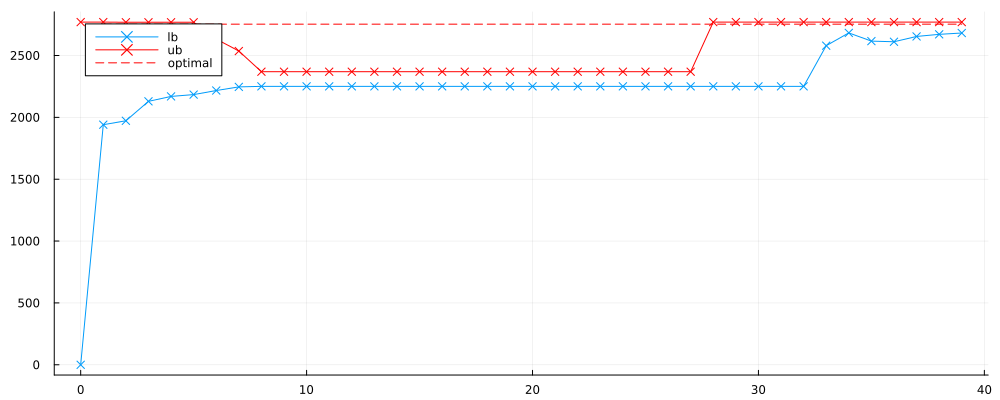

In [109]:
ordered_lb = sort(res[12])
ordered_ub = sort(res[13])

of_val = 2753.1442

# LB
plot(0:status.nIter, collect(values(ordered_lb)), label="lb",
    size=(1000,400), markershape=:xcross, legend=:topleft)

# UB
plot!(0:status.nIter, collect(values(ordered_ub)), label="ub",
    size=(1000,400), markershape=:xcross, color=:red)

# LP relaxation optimal
# plot!(1:status.nIter, zeros(status.nIter).+of_val_rel, label="lp relax optimal", color=:orange, linestyle = :dash)
# Optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash)

In [197]:
# Instance Own/18_3 with bendersIter
ordered_lb = sort(res[12])
ordered_ub = sort(res[13])

# of_val = 7555.2078
# of_val_rel = 5951.6929
# gaps = [10e-3, 5e-2, 10e-2]
# refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_lb))[2:end])#, label="lb")#,
    # size=(1000,400), markershape=:xcross, legend=:topleft)

# LP relaxation optimal
# plot!(1:status.nIter, zeros(status.nIter).+of_val_rel, label="lp relax optimal", color=:orange, linestyle = :dash)
# Optimal
# plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash)
# Gaps
# for i in 1:length(gaps)
#     gap = gaps[i]
#     plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash)
# end
# plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

# title!("I = 250, J = 10 with $solve_method - Papadakos (3h - time lim)")

# xlims!(0, 100)

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [ ]:
ordered_lb = sort(res[end-1])
ordered_ub = sort(res[end]);
# Instance Own/18_3 with benders_cb
of_val = 7555.2078
of_val_rel = 5070.6749
gaps = [10e-3, 5e-2, 10e-2, round(abs(of_val-last(collect(values(ordered_ub)))/of_val),digits=2)]
refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_ub)), label="ub",
    size=(1000,400), markershape=:xcross, legend=:topleft)

# LP relaxation optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val_rel, label="lp relax optimal", color=:orange, linestyle = :dash)
# Optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash)
# Gaps
# for i in 1:length(gaps)
#     gap = gaps[i]
#     plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash)
# end
# plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

title!("I = 250, J = 10 with $solve_method - Papadakos (163 s)")

xlims!(0, 100)

In [ ]:
# Instance Own/6
of_val = 1914.4834
gaps = [10e-3, 5e-2, 10e-2, round(abs(of_val-ordered_lb[res[end-1]])/of_val,digits=2)]
refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_lb)), label="lb",
    size=(1000,400), markershape=:xcross)
plot!(1:status.nIter, collect(values(ordered_ub)), label="ub", markershape=:xcross)
# ylims!(1500, 4000)
# Optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash, lw=1)
# Gaps
for i in 1:length(gaps)
    gap = gaps[i]
    plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash, lw=1)
    annotate!(status.nIter, refs[i], text("$gap", :left, 12, :black))
end
plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

title!("I = 20, J = 3")